In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt
import ctoolbox

import pdb
import collections
from pathlib import Path
import json
from matplotlib import patches, patheffects


In [3]:
from encoder import DataEncoder
import multibox_layer as Mlayer
import multibox_loss as Mloss

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 1. Load database

In [4]:
root_dir = '/datasets/ee285f-public/PascalVOC2012/JPEGImages/'

In [5]:
class PascalVocDataset(td.Dataset):
    img_size = 300
    
    def __init__(self, root_dir, mode='train'):
        super(PascalVocDataset, self).__init__()
        self.root_dir = root_dir
        self.mode = mode
        self.dict= json.load( (Path().absolute()/('pascal_%s2012.json'%mode)).open())      
        # id :  bbox/class id  
        annotation=collections.defaultdict(lambda:[])
        for o in self.dict['annotations']:
            if not o['ignore']:
                bb = o['bbox']
                bb = ctoolbox.hw_bb(bb)
                annotation[o['image_id']].append((bb,o['category_id']))
        self.anno = annotation
        #class 
        self.class_dict = {o['id']:o['name'] for o in self.dict['categories']}
        self.data_encoder =  DataEncoder()
        
    def __len__(self):
        return len(self.dict['images'])
    
    def __repr__(self):
        return "PascalVocDataset(mode={})".format(self.mode)
    
    def __getitem__(self, idx):
        fname = self.dict['images'][idx]['file_name']
        img_id = self.dict['images'][idx]['id']
        #pdb.set_trace()        
        img_path = os.path.join(self.root_dir, fname)
        x = Image.open(img_path).convert('RGB')        
        anno = self.anno[img_id]     
        boxes = []
        labels = []
        for i in anno:
            boxes.append(i[0])
            labels.append(i[1])
        w,h = x.size
        
#         pdb.set_trace()
        boxes_t = torch.Tensor(boxes)
        labels_t = torch.LongTensor(labels)
        
        boxes_t /=torch.Tensor([w,h,w,h]).expand_as(boxes_t)
        labels_t = torch.LongTensor(labels_t)
        
        D_encode =self.data_encoder
        loc_target, conf_target = D_encode.encode(boxes_t,labels_t)
        
        x = x.resize((self.img_size,self.img_size))
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) #imageNet Stats
        ])
        x = transform(x) 
        d = [loc_target,conf_target]

        return x,d
    def getclass(self,idx):
        return self.class_dict[idx]
        

## 2. Draw image and bbox 

In [6]:
def myimshow(image, ax=plt):
    '''
    Accept image as tensor
    '''
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

## 3. Network architect

In [42]:
vgg = tv.models.vgg16_bn(pretrained = True)
# print(vgg)

In [9]:
class L2Norm(nn.Module):
    '''L2Norm layer across all channels.'''
    def __init__(self, in_features, scale):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters(scale)

    def reset_parameters(self, scale):
        nn.init.constant(self.weight, scale)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        scale = self.weight[None,:,None,None]
        return scale * x


In [10]:
class SSDLoss(nn.Module):
    def __init__(self, num_classes):
        super(SSDLoss, self).__init__()
        self.num_classes = num_classes

    def _hard_negative_mining(self, cls_loss, pos):
        '''Return negative indices that is 3x the number as postive indices. 8732

        Args:
          cls_loss: (tensor) cross entroy loss between cls_preds and cls_targets, sized [N,#anchors].
          pos: (tensor) positive class mask, sized [N,#anchors].

        Return:
          (tensor) negative indices, sized [N,#anchors].
        '''
        cls_loss = cls_loss * (pos.float() - 1)

        _, idx = cls_loss.sort(1)  # sort by negative losses
        _, rank = idx.sort(1)      # [N,#anchors]

        num_neg = 3*pos.sum(1)  # [N,]
        neg = rank < num_neg[:,None]   # [N,#anchors]
        return neg

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        #anchors =
        Args:
          loc_preds: (tensor) predicted locations, sized [N, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [N, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [N, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [N, #anchors].

        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + CrossEntropyLoss(cls_preds, cls_targets).
        '''
        pos = cls_targets > 0  # [N,#anchors]
        batch_size = pos.size(0)
        num_pos = pos.sum().item()

        #===============================================================
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        #===============================================================
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        loc_loss = F.smooth_l1_loss(loc_preds[mask], loc_targets[mask], size_average=False)

        #===============================================================
        # cls_loss = CrossEntropyLoss(cls_preds, cls_targets)
        #===============================================================
        cls_loss = F.cross_entropy(cls_preds.view(-1,self.num_classes), \
                                   cls_targets.view(-1), reduce=False)  # [N*#anchors,]
        cls_loss = cls_loss.view(batch_size, -1)
        cls_loss[cls_targets<0] = 0  # set ignored loss to 0
        neg = self._hard_negative_mining(cls_loss, pos)  # [N,#anchors]
        cls_loss = cls_loss[pos|neg].sum()

        print('loc_loss: %.3f | cls_loss: %.3f \n' % (loc_loss.item()/num_pos, cls_loss.item()/num_pos), end=' | ')
        loss = (loc_loss+cls_loss)/num_pos
        return loss


In [26]:
 print('loc_loss:  | cls_loss:  \n')

loc_loss:  | cls_loss:  



In [28]:
class SSD300(nt.NeuralNetwork):
    input_size = 300
    
    def __init__(self):
        super(SSD300, self).__init__()

        # model
        self.base = self.VGG16()
        self.norm4 = L2Norm(512,20)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3)

        # multibox layer
        self.multibox = Mlayer.MultiBoxLayer()
        self.SSDLoss = SSDLoss(num_classes=21)       

    def VGG16(self):
        '''VGG16 layers.'''
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(True)]        
                in_channels = x
#         use pretrained VGG
#         vgg = tv.models.vgg16_bn(pretrained = True)
#         ssd_feat_extract =  vgg.features[:33]
        return nn.Sequential(*layers)

    def forward(self, x):
        hs = []
        h = self.base(x)
        hs.append(self.norm4(h))  # conv4_3

        h = F.max_pool2d(h, kernel_size=2, stride=2, ceil_mode=True)

        h = F.relu(self.conv5_1(h))
        h = F.relu(self.conv5_2(h))
        h = F.relu(self.conv5_3(h))
        h = F.max_pool2d(h, kernel_size=3, padding=1, stride=1, ceil_mode=True)

        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        hs.append(h)  # conv7

        h = F.relu(self.conv8_1(h))
        h = F.relu(self.conv8_2(h))
        hs.append(h)  # conv8_2

        h = F.relu(self.conv9_1(h))
        h = F.relu(self.conv9_2(h))
        hs.append(h)  # conv9_2

        h = F.relu(self.conv10_1(h))
        h = F.relu(self.conv10_2(h))
        hs.append(h)  # conv10_2

        h = F.relu(self.conv11_1(h))
        h = F.relu(self.conv11_2(h))
        hs.append(h)  # conv11_2

        loc_preds, conf_preds = self.multibox(hs)
        return (loc_preds, conf_preds)
    
    def criterion(self, y, d):
#       Args:
#           loc_preds: (tensor) predicted locations, sized [batch_size, 8732, 4]. y[0]
#           loc_targets: (tensor) encoded target locations, sized [batch_size, 8732, 4]. d[0]
#           conf_preds: (tensor) predicted class confidences, sized [batch_size, 8732, num_classes]. y[1]
#           conf_targets: (tensor) encoded target classes, sized [batch_size, 8732]. d[1]
        loc_preds,conf_preds = y
        loc_targets,conf_targets = d
#         pdb.set_trace() 
        loss = self.SSDLoss(loc_preds, loc_targets, conf_preds, conf_targets)        
        return loss


In [29]:
net0 = SSD300()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


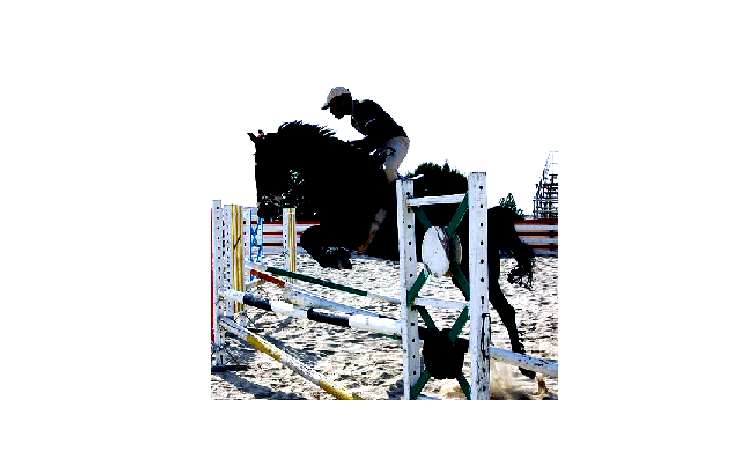

<IPython.core.display.Javascript object>


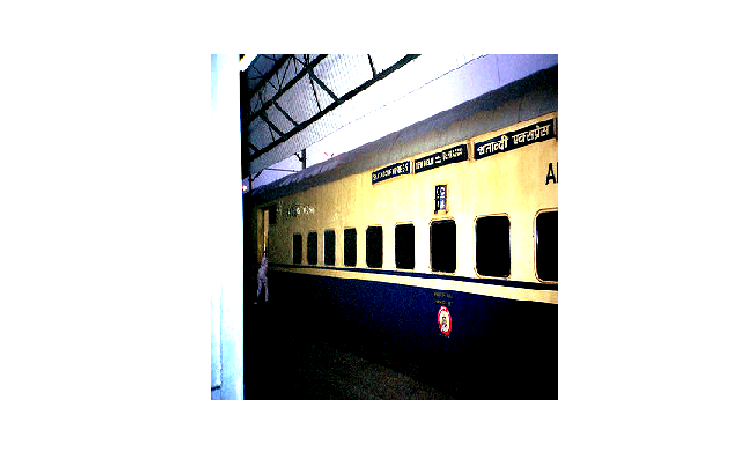

In [34]:
train_set= PascalVocDataset(root_dir)
x, d= train_set[0]
plt.figure(figsize=(5,3))
myimshow(x)
test_set= PascalVocDataset(root_dir,mode = 'val')
xv, dv= test_set[1]
plt.figure(figsize=(5,3))
myimshow(xv)

In [ ]:
train_loader = td.DataLoader(train_set, batch_size =4,
                             shuffle=True, pin_memory = True)

In [ ]:
class SSDStatsManager(nt.StatsManager):        
    def __init__(self):        
        super(SSDStatsManager, self).__init__()
        
    def init(self):
        super(SSDStatsManager, self).init()

        
    def accumulate(self, loss, x, y, d):
        super(SSDStatsManager, self).accumulate(loss, x, y, d)
#         n = np.prod(y.shape)

        
    def summarize(self):
        loss = super(SSDStatsManager, self).summarize()
        return {'loss': loss}

In [ ]:
lr = 1e-3
net = SSD300()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

stats_manager = SSDStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, optimizer, stats_manager,
                     output_dir="SSD1", batch_size = 4,perform_validation_during_training=True)

In [23]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # COMPLETE
    plt.tight_layout()
    fig.canvas.draw()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))